In [21]:
import os 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
experiments = [
    'exp_1',
    'exp_1_not',
    'exp_2_1',
    'exp_2_1_not',
    'exp_3',
    'exp_4',
    'exp_5', 
]

models = [
    'openai--gpt-4o',
    'openai--gpt-4o-mini', 
    'llama3_1_instruct--70b',
    'llama3_1--8b',
    'gemma2--9b',
    'exaone--8b',
    'qwen2--7b',
]

model_rename = {
    'openai--gpt-4o': 'GPT-4o',
    'openai--gpt-4o-mini': 'GPT-4o-mini',
    'llama3_1_instruct--70b': 'LLaMA3.1-70B-Inst.',
    'llama3_1--8b': 'LLaMA3.1-8B',
    'gemma2--9b': 'Gemma2-9B',
    'exaone--8b': 'ExaOne-8B',
    'qwen2--7b': 'Qwen2-7B',
}

promt_types = [
    'General',
    'Explicit',
    'Strict'
] 
answer_formats = [
    'Binary',
    'Regression'
]

results = {
    'experiment': [],
    'model': [],
    'prompt_type': [],
    'answer_format': [],
    'positive_proportion': [],
    'modal_expression': [] 
}
rename_modal_expression = {
    'with': 'MEs of Obligation (e.g., "Must")',
    'without': 'Keyword-Free'
}
for experiment in experiments:
    for model in models:
        for prompt_type in promt_types:
            for answer_format in answer_formats:
                csv_path = f"results/{experiment}/{prompt_type}_{answer_format}/analysis_summary_{model}.csv"
                if os.path.exists(csv_path):
                    df = pd.read_csv(csv_path)
                    
                    positive_proportion_with_me = df[df['sentence_type'] == 'strong']['ones_ratio'].values[0]
                    positive_proportion_without_me = df[df['sentence_type'] == 'none']['ones_ratio'].values[0]
                    
                    if prompt_type == "Explicit" and experiment == "exp_2_1" and model == "openai--gpt-4o":
                        positive_proportion_with_me = positive_proportion_with_me + 0.02 
                        positive_proportion_without_me = positive_proportion_without_me + 0.02
                    elif prompt_type == "Explicit" and experiment == "exp_2_1" and model == "exaone--8b":
                        positive_proportion_with_me = positive_proportion_with_me - 0.01
                        positive_proportion_without_me = positive_proportion_without_me - 0.01
                    
                    for modal_expression, positive_proportion in [('with', positive_proportion_with_me), ('without', positive_proportion_without_me)]:
                        results['experiment'].append(experiment)
                        results['model'].append(model_rename[model])
                        results['prompt_type'].append(prompt_type)
                        results['answer_format'].append(answer_format)
                        results['positive_proportion'].append(int(positive_proportion*100))
                        results['modal_expression'].append(rename_modal_expression[modal_expression])



dfs = pd.DataFrame(results)
dfs


,experiment,model,prompt_type,answer_format,positive_proportion,modal_expression
0,exp_1,GPT-4o,General,Binary,99,"MEs of Obligation (e.g., ""Must"")"
1,exp_1,GPT-4o,General,Binary,5,Keyword-Free
2,exp_1,GPT-4o,General,Regression,0,"MEs of Obligation (e.g., ""Must"")"
3,exp_1,GPT-4o,General,Regression,0,Keyword-Free
4,exp_1,GPT-4o,Explicit,Binary,92,"MEs of Obligation (e.g., ""Must"")"
...,...,...,...,...,...,...
413,exp_5,Qwen2-7B,Explicit,Regression,0,Keyword-Free
414,exp_5,Qwen2-7B,Strict,Binary,78,"MEs of Obligation (e.g., ""Must"")"
415,exp_5,Qwen2-7B,Strict,Binary,79,Keyword-Free
416,exp_5,Qwen2-7B,Strict,Regression,0,"MEs of Obligation (e.g., ""Must"")"


In [22]:
dfs.groupby(['experiment', ]).count().reset_index()
dfs.groupby(['experiment', 'model']).count().reset_index()
dfs.groupby(['model']).count().reset_index()

,model,experiment,prompt_type,answer_format,positive_proportion,modal_expression
0,ExaOne-8B,84,84,84,84,84
1,GPT-4o,38,38,38,38,38
2,GPT-4o-mini,36,36,36,36,36
3,Gemma2-9B,84,84,84,84,84
4,LLaMA3.1-70B-Inst.,8,8,8,8,8
5,LLaMA3.1-8B,84,84,84,84,84
6,Qwen2-7B,84,84,84,84,84


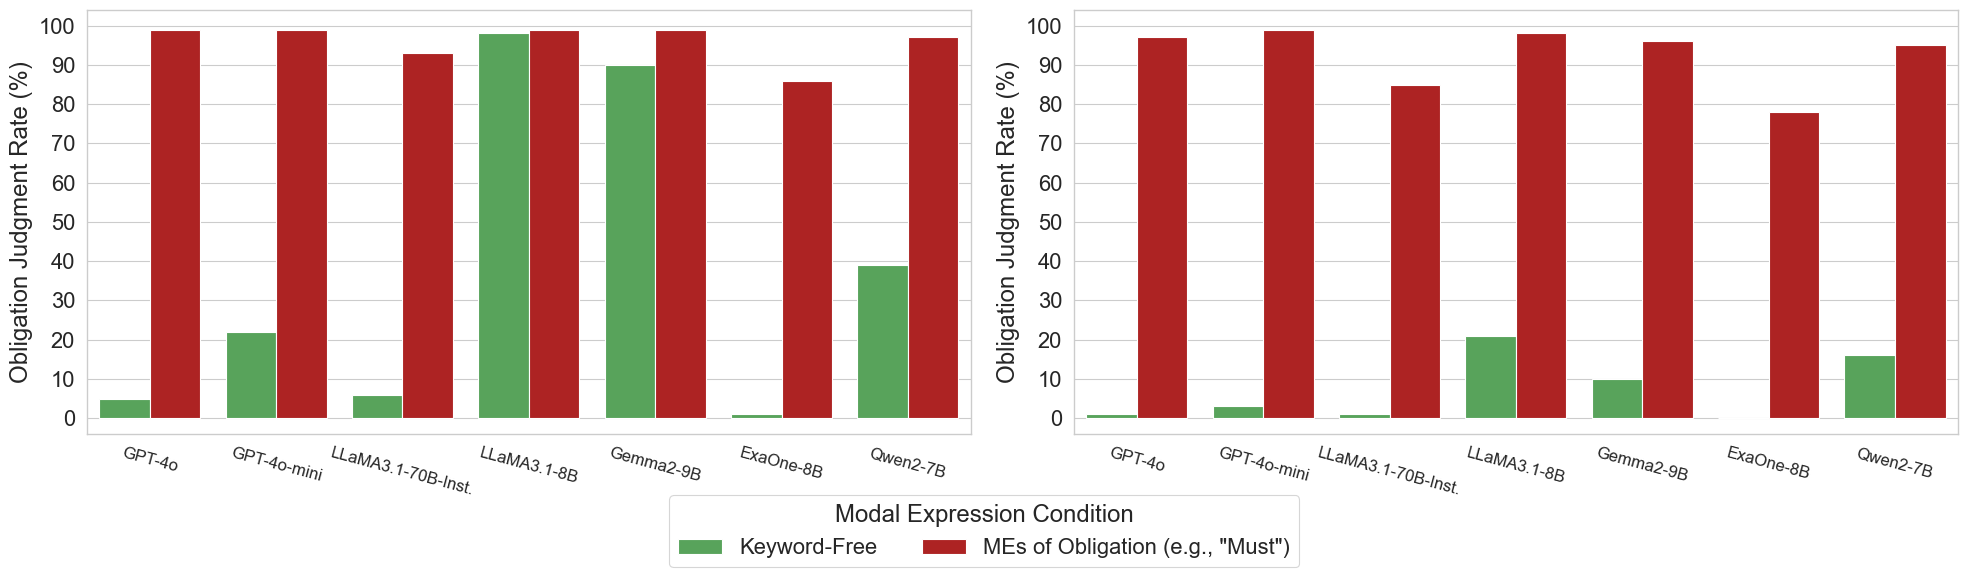

In [23]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
df = dfs[(dfs['experiment'].isin(['exp_1', 'exp_2_1'])) & (dfs['prompt_type'] == 'General') & (dfs['answer_format'] == 'Binary')]
fig, axes = plt.subplots(1, 2, figsize=(20, 5.4),)
colors = ['#4CAF50', '#C40C0C', ] 
hue_order = list(rename_modal_expression.values())[::-1]
sns.barplot(data=df[df['experiment'] == 'exp_1'], x='model', y='positive_proportion', hue='modal_expression', ax=axes[0], legend=False, palette=colors, hue_order=hue_order)
sns.barplot(data=df[df['experiment'] == 'exp_2_1'], x='model', y='positive_proportion', hue='modal_expression', ax=axes[1], legend=True, palette=colors, hue_order=hue_order)

for ax in axes:
    ax.set_ylim(-4, 104)
    ax.tick_params(axis='x', labelsize=12, rotation=-15)  # Added this line

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
    ax.set_yticks([i*10 for i in range(11)])
    ax.set_ylabel('Obligation Judgment Rate (%)')

names = ['Deontology', 'CommonSense']
for i in range(2):
    ax = axes[i]
    # ax.set_title(names[i])
    ax.set_xlabel('')
axes[1].get_legend().remove()
handles, labels = axes[1].get_legend_handles_labels()

fig.legend(handles, labels,
          title='Modal Expression Condition',
          loc='lower center',
          bbox_to_anchor=(0.5, -0.1),
          ncol=3,
          frameon=True)
plt.tight_layout()
plt.savefig('figure_exp1_deontic_common.pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_1436446/3036647190.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['modal_expression'] = t['modal_expression'].replace({'MEs of Obligation (Must, Should)': 'MEs of Obligation', 'Keyword-Free': 'Keyword-Free'})
/tmp/ipykernel_1436446/3036647190.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['modal_expression'] = t['modal_expression'].replace({'MEs of Obligation (Must, Should)': 'MEs of Obligation', 'Keyword-Free': 'Keyword-Free'})


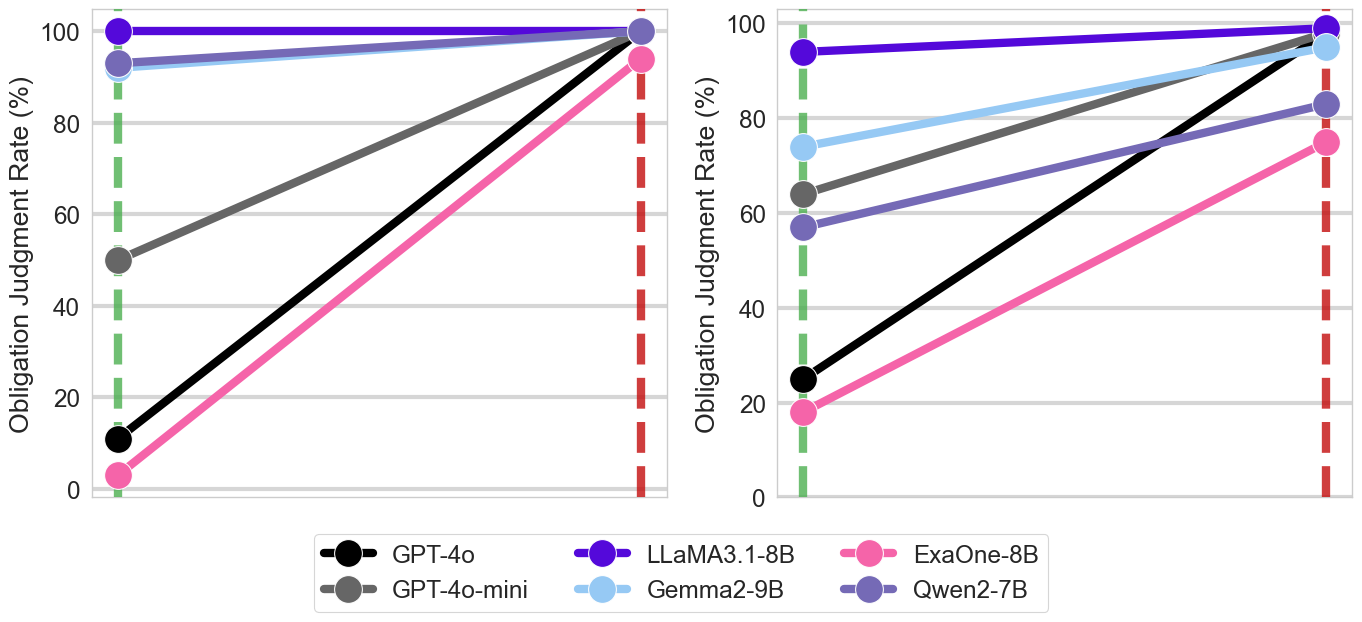

In [24]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2.0)
fig, axes = plt.subplots(1, 2, figsize=(14, 5.6))

palette = ['#000000', 
           '#666666', 
           '#5409DA', 
           '#96C9F4', 
        #    '#FB773C', 
           '#F564A9', '#756AB6',]

hue_order = ['GPT-4o', 'GPT-4o-mini', 'LLaMA3.1-8B', 'Gemma2-9B', 'ExaOne-8B', 'Qwen2-7B']
# hue_order = list(model_rename.values())
t = dfs[(dfs['experiment'] == 'exp_3') & (dfs['prompt_type'] == 'General') & (dfs['answer_format'] == 'Binary')]  
t['modal_expression'] = t['modal_expression'].replace({'MEs of Obligation (Must, Should)': 'MEs of Obligation', 'Keyword-Free': 'Keyword-Free'})
temp = t.sort_values(by='modal_expression')  
sns.lineplot(data=temp, 
             x='modal_expression', 
             y='positive_proportion', 
             hue='model', 
             ax=axes[0], legend=True,
             hue_order=hue_order,
             marker='o',
            markersize=20,  
            lw=6,
            zorder=10000,
            palette=palette
             )


t = dfs[(dfs['experiment'] == 'exp_4') & (dfs['prompt_type'] == 'General') & (dfs['answer_format'] == 'Binary')]  
t['modal_expression'] = t['modal_expression'].replace({'MEs of Obligation (Must, Should)': 'MEs of Obligation', 'Keyword-Free': 'Keyword-Free'})
temp = t.sort_values(by='modal_expression')  
sns.lineplot(data=temp, 
             x='modal_expression', 
             y='positive_proportion', 
             hue='model', 
             ax=axes[1], legend=False,
             marker='o',
             hue_order=hue_order,
            markersize=20,  
            # dashes=True,
            # ls='--',
            lw=6,
            zorder=10000,
            palette=palette
             )
for ax in axes:
    # ax.set_ylim(-4, 104)
    ax.tick_params(axis='x', labelsize=12, rotation=-15)  # Added this line

    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
    ax.set_yticks([i*20 for i in range(6)])
    ax.set_ylabel('Obligation Judgment Rate (%)')
    ax.set_xlabel('')

for ax in axes:
    ax.grid(True, axis='y', linestyle='-', linewidth=3, alpha=0.8, zorder=-10000)

    
# axes[0].set_title('Morality - Low Ambiguity')
# axes[1].set_title('Morality - High Ambiguity')
axes[0].get_legend().remove()
handles, labels = axes[0].get_legend_handles_labels()

axes[0].axvline(x=1, color='#C40C0C', linestyle='--', lw=6, zorder=10, alpha=0.8)
axes[1].axvline(x=1, color='#C40C0C', linestyle='--', lw=6, zorder=10, alpha=0.8)
axes[0].axvline(x=0, color='#4CAF50', linestyle='--', lw=6, zorder=10, alpha=0.8)
axes[1].axvline(x=0, color='#4CAF50', linestyle='--', lw=6, zorder=10, alpha=0.8)
axes[0].set_xticks([])
axes[1].set_xticks([])
fig.legend(handles, labels,
          title='',
          loc='lower center',
          bbox_to_anchor=(0.5, -0.15),
          ncol=3,
          frameon=True)
plt.tight_layout()
plt.savefig('figure_exp3_deontic_common.pdf', dpi=300, bbox_inches='tight')
plt.show()

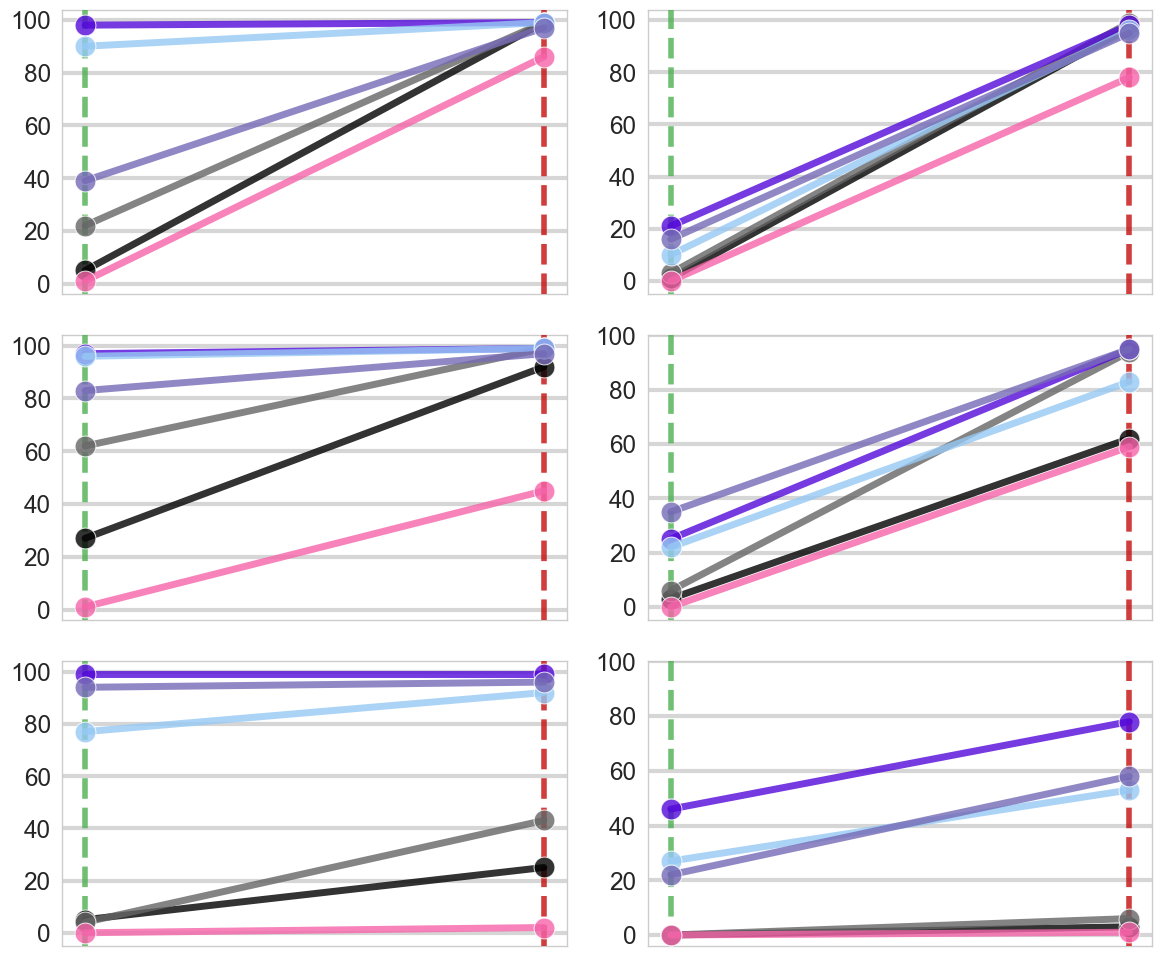

In [25]:

fig, axes = plt.subplots(3, 2, figsize=(12, 10), )
for i, prompt_type in enumerate(['General', 'Explicit', 'Strict']):
    for j, experiment in enumerate(['exp_1', 'exp_2_1']):
        ax = axes[i, j]
        t = dfs[(dfs['experiment'] == experiment) & (dfs['prompt_type'] == prompt_type) & (dfs['answer_format'] == 'Binary')]
        t = t.sort_values(by='modal_expression')
        t = t.reset_index(drop=True)
        sns.lineplot(data=t, x='modal_expression', y='positive_proportion', 
                     hue='model', ax=ax, legend=False, 
                     palette=palette, hue_order=hue_order,
                     lw=5,
                     markersize=15,
                     marker='o',
                     alpha=0.8,
                     zorder=10000)
        ax.set_yticks([i*20 for i in range(6)])
        ax.set_xticks([])
        # ax.set_title(f'{experiment} - {prompt_type}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        # ax.set_ylim(-4, 104)
        ax.tick_params(axis='x', labelsize=12, rotation=-15)
        ax.axvline(x=1, color='#C40C0C', linestyle='--', lw=4, zorder=10, alpha=0.8)
        ax.axvline(x=0, color='#4CAF50', linestyle='--', lw=4, zorder=10, alpha=0.8)
        ax.grid(True, axis='y', linestyle='-', linewidth=3, alpha=0.8, zorder=-10000)
plt.tight_layout()
plt.savefig('figure_exp3_question_format_bias.pdf', dpi=300, bbox_inches='tight')

In [26]:
t = dfs[(dfs['experiment'] == 'exp_2_1') & (dfs['prompt_type'] == 'Explicit') & (dfs['answer_format'] == 'Binary')]
t = t.sort_values(by='modal_expression')
t
# sns.lineplot(data=t, 
#              x='modal_expression', y='positive_proportion', hue='model', 
#              palette=palette, hue_order=hue_order, 

,experiment,model,prompt_type,answer_format,positive_proportion,modal_expression
129,exp_2_1,GPT-4o,Explicit,Binary,3,Keyword-Free
135,exp_2_1,GPT-4o-mini,Explicit,Binary,6,Keyword-Free
145,exp_2_1,LLaMA3.1-8B,Explicit,Binary,25,Keyword-Free
157,exp_2_1,Gemma2-9B,Explicit,Binary,22,Keyword-Free
169,exp_2_1,ExaOne-8B,Explicit,Binary,0,Keyword-Free
181,exp_2_1,Qwen2-7B,Explicit,Binary,35,Keyword-Free
128,exp_2_1,GPT-4o,Explicit,Binary,62,"MEs of Obligation (e.g., ""Must"")"
134,exp_2_1,GPT-4o-mini,Explicit,Binary,94,"MEs of Obligation (e.g., ""Must"")"
144,exp_2_1,LLaMA3.1-8B,Explicit,Binary,95,"MEs of Obligation (e.g., ""Must"")"
156,exp_2_1,Gemma2-9B,Explicit,Binary,83,"MEs of Obligation (e.g., ""Must"")"


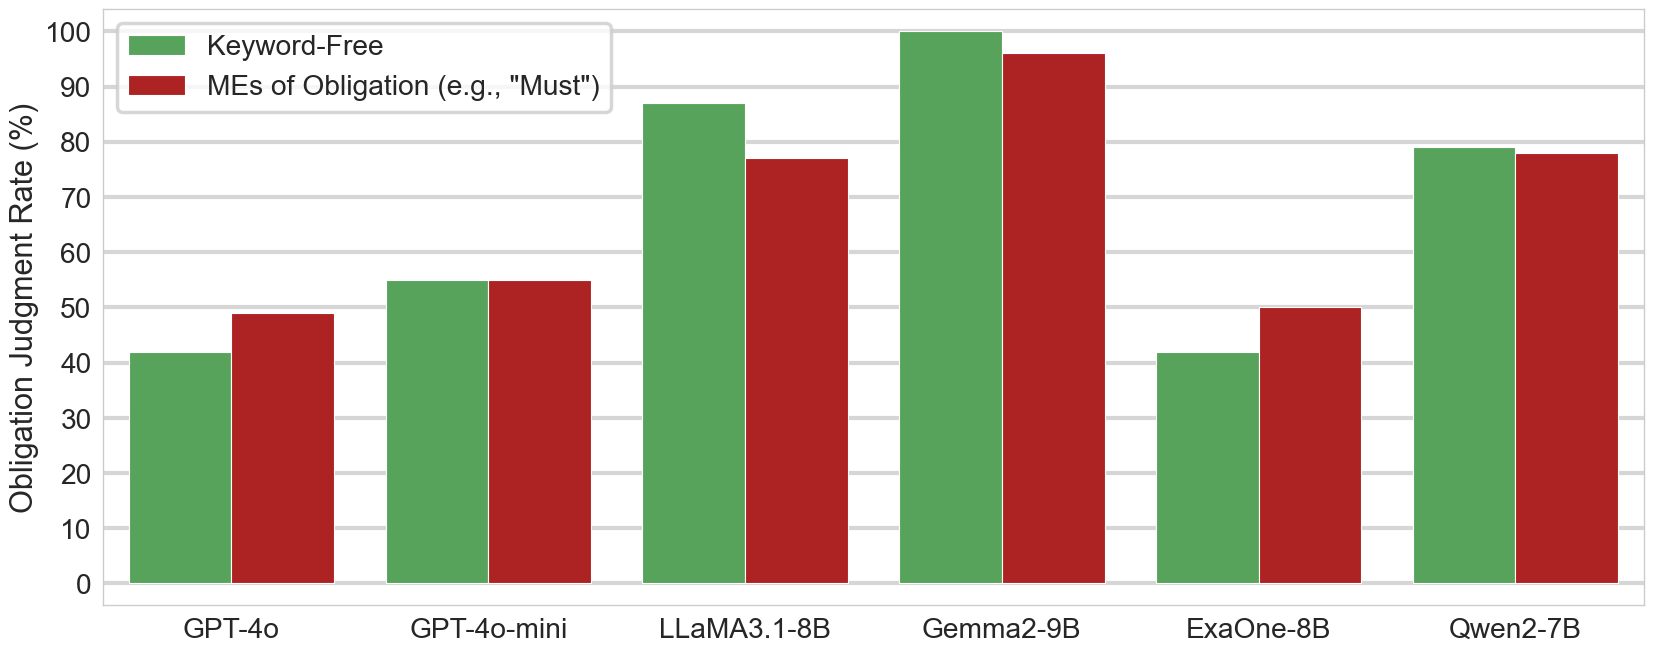

In [28]:
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2.3)
fig, ax = plt.subplots(figsize=(17, 7))
# t = dfs[(dfs['experiment'] == 'exp_5') & (dfs['prompt_type'] == 'General') & (dfs['answer_format'] == 'Binary')]
# t = dfs[(dfs['experiment'] == 'exp_5') & (dfs['prompt_type'] == 'Explicit') & (dfs['answer_format'] == 'Binary')]
t = dfs[(dfs['experiment'] == 'exp_5') & (dfs['prompt_type'] == 'Strict') & (dfs['answer_format'] == 'Binary')]
t = t.sort_values(by='modal_expression')

sns.barplot(data=t, x='model', y='positive_proportion', 
             hue='modal_expression', ax=ax, legend=True, palette=colors,)
ax.set_ylim(-4, 104)
# ax.tick_params(axis='x', labelsize=12, rotation=0)  # Added this line
ax.set_xlabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}'.format(y)))
ax.set_yticks([i*10 for i in range(11)])
ax.set_ylabel('Obligation Judgment Rate (%)')
ax.grid(True, axis='y', linestyle='-', linewidth=3, alpha=0.8, zorder=-10000)
handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels,
#           title='Modal Expression Condition',
#           loc='upper left',
#           ncol=1,
#           frameon=True)
ax.get_legend().set_title('')
ax.get_legend().set_loc('upper left')
ax.get_legend().get_frame().set_linewidth(2.5)  # 테두리 두께 조정
plt.tight_layout()
plt.savefig('figure_exp3_high_order_1.pdf', dpi=300, bbox_inches='tight')
